# BAX-453 Team Assignment

In [1]:
# load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import random
import re
import scipy
from scipy import sparse
import seaborn as sns
# nlp 
import nltk 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
from sklearn.feature_extraction.text import CountVectorizer
# word embedding
import gensim 
#from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import gensim 
# sentiment
from textblob import TextBlob
# machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection  import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection  import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")
from sklearn.pipeline import Pipeline

# Load data

In [2]:
# load data from local path
df_reviews = pd.read_json('C:/Users/yifang/Desktop/UCD/BAX-453-001 Application Domains/Team Assignment/Health_and_Personal_Care_5.json', lines=True)
df_reviews.head(5)

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,159985130X,"[1, 1]",5,This is a great little gadget to have around. ...,"01 5, 2011",ALC5GH8CAMAI7,AnnN,Handy little gadget,1294185600
1,159985130X,"[1, 1]",4,I would recommend this for a travel magnifier ...,"02 18, 2012",AHKSURW85PJUE,"AZ buyer ""AZ buyer""",Small & may need to encourage battery,1329523200
2,159985130X,"[75, 77]",4,What I liked was the quality of the lens and t...,"06 8, 2010",A38RMU1Y5TDP9,"Bob Tobias ""Robert Tobias""",Very good but not great,1275955200
3,159985130X,"[56, 60]",4,Love the Great point light pocket magnifier! ...,"02 8, 2008",A1XZUG7DFXXOS4,Cat lover,great addition to your purse,1202428800
4,159985130X,"[1, 1]",5,This is very nice. You pull out on the magnifi...,"08 16, 2011",A1MS3M7M7AM13X,Cricketoes,Very nice and convenient.,1313452800


In [3]:
# use subset of data to run (choose 30%)
df_reviews = df_reviews.sample(frac=0.3, random_state=1)

# Text vectorization techniques 

In [4]:
# convert text to lower case 
reviews = df_reviews["reviewText"].str.lower()

# remove numbers
reviews = reviews.replace("\d+", '')

# words Tokenization
reviews = reviews.apply(word_tokenize)

# remove non-English words
engwords = set(nltk.corpus.words.words())
reviews = reviews.apply(lambda x: [w for w in x if w in engwords])

# remove punctuation
punctuations = list(string.punctuation)
reviews = reviews.apply(lambda x: 
            [i.strip("".join(punctuations)) for i in x if i not in punctuations])

# handle negations
def handleNegations (text):
    for i in range(len(text)-1):
        if text[i] == "not":
            text[i] == ""
            text[i+1] =="not_"+text[i+1]
        elif "n't" in text[i]:
            text[i] = text[i].replace("n't", "")
            text[i+1] = "not_"+text[i+1]
        else: continue
    return text

reviews = reviews.apply(handleNegations)

# remove stop words 
stop_words=set(stopwords.words("english"))
reviews = reviews.apply(lambda x: [item for item in x if item not in stop_words])

# stem words 
porter_stemmer = PorterStemmer()
stemmed_reviews = reviews.apply(lambda x: [porter_stemmer.stem(y) for y in x])

print(stemmed_reviews)

183867    [go, easi, pleasur, wear, right, foot, sometim...
228691    [great, product, mix, go, work, well, use, sma...
104561             [sister, felt, better, take, that, give]
202076    [get, mani, recent, quit, bad, one, seem, help...
233799    [great, pillow, best, like, cut, roll, onto, s...
278249    [cancer, tri, get, nutrit, everi, day, battl, ...
186846    [receiv, scale, size, great, husband, size, ac...
17817     [product, actual, good, econom, hope, accompli...
282448    [high, hope, product, especi, could, tell, dif...
220272    [tinctur, benzoin, great, adhes, especi, like,...
302941    [work, appetit, main, problem, weight, blood, ...
21393     [love, stuff, realli, work, heal, muscl, worko...
85588     [great, product, one, want, use, dust, two, du...
169329    [item, sleep, better, night, job, well, get, g...
33701               [exactli, access, easi, transport, use]
191938    [well, laundri, deterg, hard, find, much, say,...
337163    [fan, blend, white, mulberri, 

### Bag of Words 

In [5]:
stemwords = stemmed_reviews.copy()
stemwords = stemwords.apply(lambda x: ','.join(x))

In [6]:
def topN_dict(corpus, n=None):
    count_vec = CountVectorizer()
    texts = count_vec.fit_transform(corpus)
    sum_words = texts.sum(axis=0)
    freqs = [[word, sum_words[0, idx]] for word, idx in count_vec.vocabulary_.items()]
    words_sorted_freq = sorted(freqs, key = lambda x: x[1], reverse=True)
    return words_sorted_freq[:n]

In [7]:
top_text = topN_dict(stemwords, 500)

word_vec = list()
for key, value in top_text:
    word_vec.append(key)

In [8]:
doc_matrix = []
for doc in stemmed_reviews:
    bag_vec = np.zeros(len(word_vec))
    for w in doc:
        for i, word in enumerate(word_vec):
            if word == w:
                bag_vec[i]+=1
    doc_matrix.append(np.array(bag_vec))

In [9]:
# results could be used in model building 
df_bow = pd.DataFrame(np.row_stack(doc_matrix), columns=word_vec)
df_bow.head()

,use,product,work,like,one,get,good,take,would,great,...,activ,essenti,thin,pick,follow,beard,adjust,exercis,monitor,eye
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
df_bow.shape

(103906, 500)

### TF-IDF 

In [11]:
vectorizer=TfidfVectorizer(use_idf=True)
features=vectorizer.fit_transform(stemwords)
features

<103906x15933 sparse matrix of type '<class 'numpy.float64'>'
	with 3067316 stored elements in Compressed Sparse Row format>

In [12]:
# results could be used in model building 
df_tfidf_features = pd.DataFrame(features.todense(), columns=vectorizer.get_feature_names())
df_tfidf_features.head()

,aa,aba,aback,abandon,abat,abb,abbot,abbrevi,abdomen,abdomin,...,zippi,zircon,zirconium,zoic,zombi,zone,zoo,zoom,zoonot,zucchini
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### n-Grams - bigrams

In [13]:
# create bi-grams
def topN_bigram_dict(corpus, n=None):
    count_vec = CountVectorizer(analyzer='word', ngram_range=(1, 2), stop_words='english')
    gram_vec = count_vec.fit_transform(corpus)
    sum_words = gram_vec.sum(axis=0)
    freqs = [[word, sum_words[0, idx]] for word, idx in count_vec.vocabulary_.items()]
    words_sorted_freq = sorted(freqs, key = lambda x: x[1], reverse=True)
    return words_sorted_freq[:n]

In [14]:
top_bigrams = topN_bigram_dict(stemwords, 500)

bigram_vec = list()
for key, value in top_bigrams:
    bigram_vec.append(key)

In [15]:
doc_bigram_matrix = []
for doc in stemmed_reviews:
    bag_vec = np.zeros(len(bigram_vec))
    for w in doc:
        for i, word in enumerate(bigram_vec):
            if word == w:
                bag_vec[i]+=1
    doc_bigram_matrix.append(np.array(bag_vec))

In [16]:
# results could be used in model building 
df_bigram = pd.DataFrame(np.row_stack(doc_bigram_matrix), columns=bigram_vec)
df_bigram.head()

,use,product,work,like,good,great,time,tri,day,realli,...,capsul,meal,blue,stain,aid,walk,mop,tight,serv,dog
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
df_bigram.shape

(103906, 500)

# Sentiment Analysis predictive models 

In [18]:
# define a function to draw ROC curve
def draw_roc_auc(y_test, X_test, method):
    logit_roc_auc = roc_auc_score(y_test, method.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, method.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

### Bag of words

In [19]:
# set up sparse matrix
bow_sparse = scipy.sparse.csr_matrix(df_bow.values)

In [20]:
# set up x
X = bow_sparse
# set up y: =1 when overall rating >= 4
y = df_reviews['overall'].apply(lambda x: 1 if x >= 4 else 0)

#train test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 28)

##### Logistic Regression

In [21]:
logreg = LogisticRegression()

In [22]:
# fit the model with data
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
# predict using test data
preds_LR=logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.83


In [24]:
# Check the Accuracy of the Model
cm_LR=pd.crosstab(y_test, preds_LR, rownames=['Actual Result'], colnames=['Predicted Result'])
cm_LR

Predicted Result,0,1
Actual Result,,
0,1444,4573
1,787,24368


In [25]:
# recall and precision
recall_LR= cm_LR.iloc[1,1]/(cm_LR.iloc[1,1]+cm_LR.iloc[1,0])
precision_LR=cm_LR.iloc[1,1]/(cm_LR.iloc[1,1]+cm_LR.iloc[0,1])
print(recall_LR,precision_LR)
F_Score_LR = (2 * recall_LR * precision_LR) / (recall_LR + precision_LR)
print('F-score of Logistic Regression: %.2f' % F_Score_LR)

0.9687139733651362 0.8419888739158978
F-score of Logistic Regression: 0.90


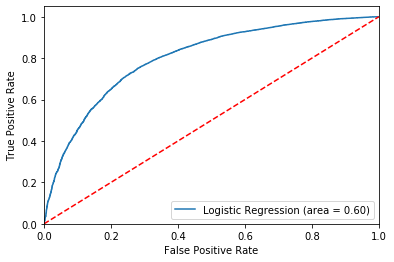

In [26]:
# ROC curve
draw_roc_auc(y_test, X_test, logreg)

##### Decision Tree

In [27]:
clf_DT = DecisionTreeClassifier()

In [28]:
clf_DT.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [29]:
# predict using test data
preds_DT = clf_DT.predict(X_test)
print('Accuracy of decision tree on test set: {:.2f}'.format(clf_DT.score(X_test, y_test)))

Accuracy of decision tree on test set: 0.75


In [30]:
# Check the Accuracy of the Model
cm_DT=pd.crosstab(y_test, preds_DT, rownames=['Actual Result'], colnames=['Predicted Result'])
cm_DT

Predicted Result,0,1
Actual Result,,
0,2169,3848
1,4046,21109


In [31]:
# recall and precision
recall_DT= cm_DT.iloc[1,1]/(cm_DT.iloc[1,1]+cm_DT.iloc[1,0])
precision_DT=cm_DT.iloc[1,1]/(cm_DT.iloc[1,1]+cm_DT.iloc[0,1])
print(recall_DT,precision_DT)
F_Score_DT = (2 * recall_DT * precision_DT) / (recall_DT + precision_DT)
print('F-score of decision tree : %.2f' %F_Score_DT)

0.8391572252037368 0.8458148014585086
F-score of decision tree : 0.84


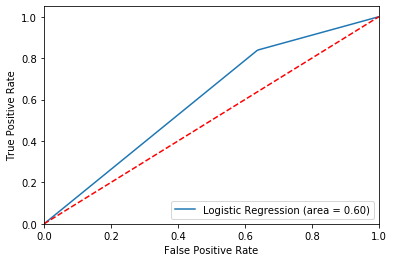

In [32]:
# ROC curve
draw_roc_auc(y_test, X_test, clf_DT)

##### Random Forest

In [33]:
clf_RF = RandomForestClassifier(n_jobs=2, random_state=0)

In [34]:
clf_RF.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [35]:
# predict using test data
preds_RF = clf_RF.predict(X_test)
print('Accuracy of Random Forest on test set: {:.2f}'.format(clf_RF.score(X_test, y_test)))

Accuracy of Random Forest on test set: 0.80


In [36]:
# Check the Accuracy of the Model
cm_RF=pd.crosstab(y_test, preds_RF, rownames=['Actual Result'], colnames=['Predicted Result'])
cm_RF

Predicted Result,0,1
Actual Result,,
0,1548,4469
1,1770,23385


In [37]:
# recall and precision
recall_RF= cm_RF.iloc[1,1]/(cm_RF.iloc[1,1]+cm_RF.iloc[1,0])
precision_RF=cm_RF.iloc[1,1]/(cm_RF.iloc[1,1]+cm_RF.iloc[0,1])
print(recall_RF,precision_RF)
F_Score_RF = (2 * recall_RF * precision_RF) / (recall_RF + precision_RF)
print('F-score of Random Forest: %.2f' %F_Score_RF)

0.9296362552176506 0.8395562576290658
F-score of Random Forest: 0.88


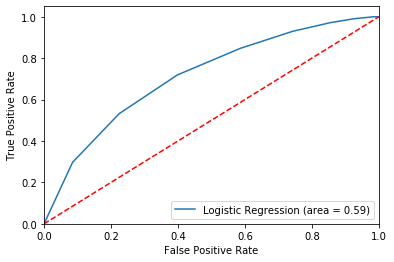

In [38]:
# ROC curve
draw_roc_auc(y_test, X_test, clf_RF)

##### GridSearchCV for bag of words

In [39]:
# Set random seed
np.random.seed(0)

In [40]:
# Create a pipeline
pipe = Pipeline([('classifier', RandomForestClassifier())])

In [41]:
# Create space of candidate learning algorithms and their hyperparameters
search_space = [{'classifier': [LogisticRegression()]},
                {'classifier': [DecisionTreeClassifier()]},
                {'classifier': [RandomForestClassifier()]}]

In [42]:
# Create grid search 
clf_compare = GridSearchCV(pipe, search_space, cv=5, verbose=0)

In [43]:
# Fit grid search
best_model = clf_compare.fit(X, y)

In [44]:
# View best model and its best hyperparameters
best_model.best_estimator_.get_params()['classifier']

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# For BoW, logistic regression is the best model

### TF-IDF

In [45]:
tfidf_sparse = scipy.sparse.csr_matrix(df_tfidf_features.values)

In [46]:
X = tfidf_sparse
y = df_reviews ['overall'].apply(lambda x: 1 if x >= 4 else 0)

#train test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 28)

##### Logistic Regression

In [47]:
logreg = LogisticRegression()

In [48]:
# fit the model with data
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [49]:
# predict using test data
preds_LR=logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.85


In [50]:
# Check the Accuracy of the Model
cm_LR=pd.crosstab(y_test, preds_LR, rownames=['Actual Result'], colnames=['Predicted Result'])
cm_LR

Predicted Result,0,1
Actual Result,,
0,2173,3844
1,878,24277


In [51]:
# recall and precision
recall_LR= cm_LR.iloc[1,1]/(cm_LR.iloc[1,1]+cm_LR.iloc[1,0])
precision_LR=cm_LR.iloc[1,1]/(cm_LR.iloc[1,1]+cm_LR.iloc[0,1])
print(recall_LR,precision_LR)
F_Score_LR = (2 * recall_LR * precision_LR) / (recall_LR + precision_LR)
print('F-score of Logistic Regression: %.2f' % F_Score_LR)

0.9650964023057046 0.8633050033782582
F-score of Logistic Regression: 0.91


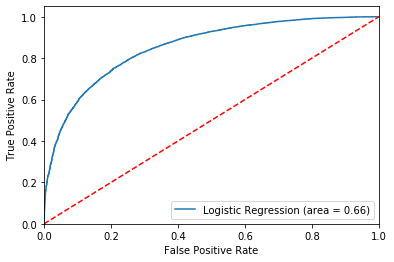

In [52]:
# ROC curve
draw_roc_auc(y_test, X_test, logreg)

##### Decision Tree

In [53]:
clf_DT = DecisionTreeClassifier()

In [54]:
clf_DT.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [55]:
# predict using test data
preds_DT = clf_DT.predict(X_test)
print('Accuracy of decision tree on test set: {:.2f}'.format(clf_DT.score(X_test, y_test)))

Accuracy of decision tree on test set: 0.76


In [56]:
# Check the Accuracy of the Model
cm_DT=pd.crosstab(y_test, preds_DT, rownames=['Actual Result'], colnames=['Predicted Result'])
cm_DT

Predicted Result,0,1
Actual Result,,
0,2071,3946
1,3578,21577


In [57]:
# recall and precision
recall_DT= cm_DT.iloc[1,1]/(cm_DT.iloc[1,1]+cm_DT.iloc[1,0])
precision_DT=cm_DT.iloc[1,1]/(cm_DT.iloc[1,1]+cm_DT.iloc[0,1])
print(recall_DT,precision_DT)
F_Score_DT = (2 * recall_DT * precision_DT) / (recall_DT + precision_DT)
print('F-score of decision tree : %.2f' %F_Score_DT)

0.8577618763665276 0.8453943501939427
F-score of decision tree : 0.85


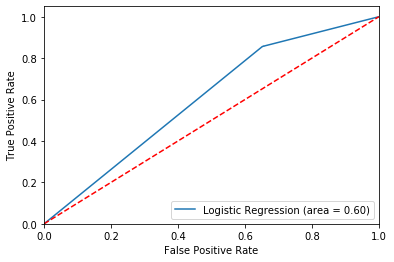

In [58]:
# ROC curve
draw_roc_auc(y_test, X_test, clf_DT)

##### Random Forest

In [59]:
clf_RF = RandomForestClassifier(n_jobs=2, random_state=0)

In [60]:
clf_RF.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [61]:
# predict using test data
preds_RF = clf_RF.predict(X_test)
print('Accuracy of Random Forest on test set: {:.2f}'.format(clf_RF.score(X_test, y_test)))

Accuracy of Random Forest on test set: 0.82


In [62]:
# Check the Accuracy of the Model
cm_RF=pd.crosstab(y_test, preds_RF, rownames=['Actual Result'], colnames=['Predicted Result'])
cm_RF

Predicted Result,0,1
Actual Result,,
0,1141,4876
1,769,24386


In [63]:
# recall and precision
recall_RF= cm_RF.iloc[1,1]/(cm_RF.iloc[1,1]+cm_RF.iloc[1,0])
precision_RF=cm_RF.iloc[1,1]/(cm_RF.iloc[1,1]+cm_RF.iloc[0,1])
print(recall_RF,precision_RF)
F_Score_RF = (2 * recall_RF * precision_RF) / (recall_RF + precision_RF)
print('F-score of Random Forest: %.2f' %F_Score_RF)

0.9694295368713973 0.833367507347413
F-score of Random Forest: 0.90


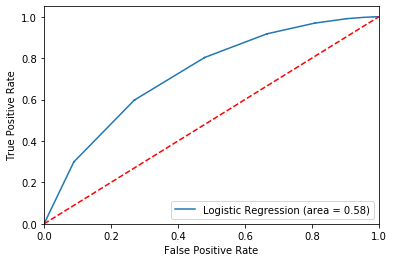

In [64]:
# ROC curve
draw_roc_auc(y_test, X_test, clf_RF)

##### GridSearchCV for TF-IDF

In [65]:
# Set random seed
np.random.seed(0)

In [66]:
# Create a pipeline
pipe = Pipeline([('classifier', RandomForestClassifier())])

In [67]:
# Create space of candidate learning algorithms and their hyperparameters
search_space = [{'classifier': [LogisticRegression()]},
                {'classifier': [DecisionTreeClassifier()]},
                {'classifier': [RandomForestClassifier()]}]

In [68]:
# Create grid search 
clf_compare = GridSearchCV(pipe, search_space, cv=5, verbose=0)

In [69]:
# Fit grid search
best_model = clf_compare.fit(X, y)

In [70]:
# View best model and its best hyperparameters
best_model.best_estimator_.get_params()['classifier']

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# For TF-IDF, logistic regression is the best model

### Bigrams

In [71]:
bigram_sparse = scipy.sparse.csr_matrix(df_bigram.values)

In [72]:
X = bigram_sparse
y = df_reviews['overall'].apply(lambda x: 1 if x >= 4 else 0)
#train test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 28)

##### Logistic Regression

In [73]:
logreg = LogisticRegression()

In [74]:
# fit the model with data
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [75]:
# predict using test data
preds_LR=logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.83


In [76]:
# Check the Accuracy of the Model
cm_LR=pd.crosstab(y_test, preds_LR, rownames=['Actual Result'], colnames=['Predicted Result'])
cm_LR

Predicted Result,0,1
Actual Result,,
0,1373,4644
1,719,24436


In [77]:
# recall and precision
recall_LR= cm_LR.iloc[1,1]/(cm_LR.iloc[1,1]+cm_LR.iloc[1,0])
precision_LR=cm_LR.iloc[1,1]/(cm_LR.iloc[1,1]+cm_LR.iloc[0,1])
print(recall_LR,precision_LR)
F_Score_LR = (2 * recall_LR * precision_LR) / (recall_LR + precision_LR)
print('F-score of Logistic Regression: %.2f' % F_Score_LR)

0.9714172132776784 0.840302613480055
F-score of Logistic Regression: 0.90


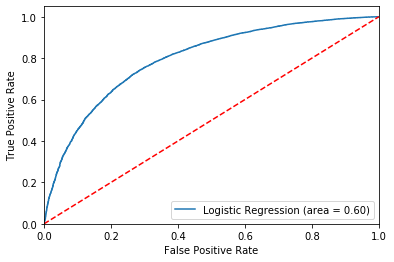

In [78]:
# ROC curve
draw_roc_auc(y_test, X_test, logreg)

##### Decision Tree

In [79]:
clf_DT = DecisionTreeClassifier()

In [80]:
clf_DT.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [81]:
# predict using test data
preds_DT = clf_DT.predict(X_test)
print('Accuracy of decision tree on test set: {:.2f}'.format(clf_DT.score(X_test, y_test)))

Accuracy of decision tree on test set: 0.74


In [82]:
# Check the Accuracy of the Model
cm_DT=pd.crosstab(y_test, preds_DT, rownames=['Actual Result'], colnames=['Predicted Result'])
cm_DT

Predicted Result,0,1
Actual Result,,
0,2131,3886
1,4153,21002


In [83]:
# recall and precision
recall_DT= cm_DT.iloc[1,1]/(cm_DT.iloc[1,1]+cm_DT.iloc[1,0])
precision_DT=cm_DT.iloc[1,1]/(cm_DT.iloc[1,1]+cm_DT.iloc[0,1])
print(recall_DT,precision_DT)
F_Score_DT = (2 * recall_DT * precision_DT) / (recall_DT + precision_DT)
print('F-score of decision tree : %.2f' %F_Score_DT)

0.8349035976942953 0.8438604950176792
F-score of decision tree : 0.84


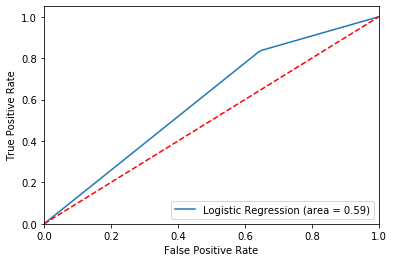

In [84]:
# ROC curve
draw_roc_auc(y_test, X_test, clf_DT)

##### Random Forest

In [85]:
clf_RF = RandomForestClassifier(n_jobs=2, random_state=0)

In [86]:
clf_RF.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [87]:
# predict using test data
preds_RF = clf_RF.predict(X_test)
print('Accuracy of Random Forest on test set: {:.2f}'.format(clf_RF.score(X_test, y_test)))

Accuracy of Random Forest on test set: 0.80


In [88]:
# Check the Accuracy of the Model
cm_RF=pd.crosstab(y_test, preds_RF, rownames=['Actual Result'], colnames=['Predicted Result'])
cm_RF

Predicted Result,0,1
Actual Result,,
0,1695,4322
1,2014,23141


In [89]:
# recall and precision
recall_RF= cm_RF.iloc[1,1]/(cm_RF.iloc[1,1]+cm_RF.iloc[1,0])
precision_RF=cm_RF.iloc[1,1]/(cm_RF.iloc[1,1]+cm_RF.iloc[0,1])
print(recall_RF,precision_RF)
F_Score_RF = (2 * recall_RF * precision_RF) / (recall_RF + precision_RF)
print('F-score of Random Forest: %.2f' %F_Score_RF)

0.919936394354999 0.8426246222189856
F-score of Random Forest: 0.88


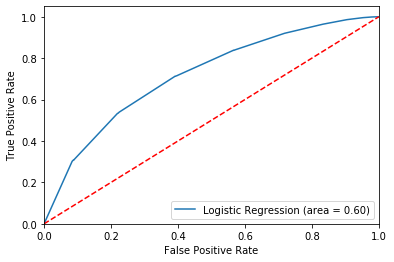

In [90]:
# ROC curve
draw_roc_auc(y_test, X_test, clf_RF)

##### GridSearchCV for Bi-Grams

In [91]:
# Set random seed
np.random.seed(0)

In [92]:
# Create a pipeline
pipe = Pipeline([('classifier', RandomForestClassifier())])

In [93]:
# Create space of candidate learning algorithms and their hyperparameters
search_space = [{'classifier': [LogisticRegression()]},
                {'classifier': [DecisionTreeClassifier()]},
                {'classifier': [RandomForestClassifier()]}]

In [94]:
# Create grid search 
clf_compare = GridSearchCV(pipe, search_space, cv=5, verbose=0)

In [95]:
# Fit grid search
best_model = clf_compare.fit(X, y)

In [96]:
# View best model and its best hyperparameters
best_model.best_estimator_.get_params()['classifier']

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# For Bi-Grams, logistic regression is the best model

### Model Selection

In [ ]:
# GridSearchCV shows that the best model is logistic regression, regardless of vectorization method.
# It is better to complement GridSearchCV with other metrics such as confusion matrix, ROC etc. in order to reach a conclusion
# Confusion matrix shows that logistic regression is better than the other two models as it has higher AUC and higher F-score

# Then we compare three logistic regression models under three vectorization methods, TF-IDF gives the best result
# so from a statistical perspective, logistic regression with TF-IDF is the best model

In [ ]:
# In out business case, false positive is less severe than false negative since taking actions to address customer
# satisfaction problem won't harm anyone; on the other hand, product marketing team might hate to lose opportunity
# to address any negative feedbacks.
# logistic regression gives the lowest false positive, thus it is still the best model from a business perspective